In [1]:
import b3d
import jax.numpy as jnp
import os
from b3d import Mesh, Pose
import jax
import genjax
from genjax import Pytree
import rerun as rr
from b3d.modeling_utils import uniform_discrete, uniform_pose, gaussian_vmf
import matplotlib.pyplot as plt
from functools import partial
import importlib

In [2]:
b3d.rr_init("interactive")
key = jax.random.PRNGKey(0)
ycb_dir = os.path.join(b3d.get_assets_path(), "bop/ycbv")
scene_id = 49
image_id = 100

all_data = b3d.io.get_ycbv_test_images(ycb_dir, scene_id, [image_id])

meshes = [
    Mesh.from_obj_file(os.path.join(ycb_dir, f'models/obj_{f"{id + 1}".rjust(6, "0")}.ply')).scale(0.001)
    for id in all_data[0]["object_types"]
]

height, width = all_data[0]["rgbd"].shape[:2]
fx,fy,cx,cy = all_data[0]["camera_intrinsics"]
scaling_factor = 0.1
renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, cx * scaling_factor, cy * scaling_factor, 0.01, 2.0
)
observed_image_scaled_down = b3d.resize_image(all_data[0]["rgbd"], renderer.height, renderer.width)

100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


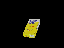

In [3]:
initial_camera_pose = all_data[0]["camera_pose"]
initial_object_poses = all_data[0]["object_poses"]
IDX = 0
pose = initial_camera_pose.inv() @ initial_object_poses[IDX]
rendered_rgbd = renderer.render_rgbd_from_mesh(meshes[IDX].transform(pose))
b3d.viz_rgb(rendered_rgbd)

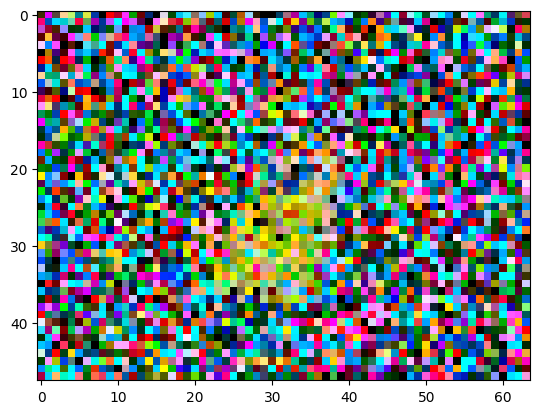

In [19]:
@genjax.gen
def ray_model(rendered_rgbd, likelihood_args):
    k = likelihood_args["k"].const
    image_height, image_width = rendered_rgbd.shape[:2]

    row_coordinate = genjax.categorical.vmap(in_axes=(0,))(
            jnp.ones((k, image_height))
    )  @ "row_coordinate"
    column_coordinate = genjax.categorical.vmap(in_axes=(0,))(
            jnp.ones((k, image_width))
    ) @ "column_coordinate"

    rgb = rendered_rgbd[row_coordinate, column_coordinate, :3]
    lab = b3d.colors.rgb_to_lab(rgb)
    depth = rendered_rgbd[row_coordinate, column_coordinate, 3]

    outlier_probability = genjax.uniform(0.0, 1.0) @ "outlier_probability"
    inlier_color_variance = genjax.uniform(0.0001, 10.0) @ "inlier_color_variance"
    inlier_lightness_variance = genjax.uniform(0.0001, 10.0) @ "inlier_lightness_variance"
    inlier_depth_variance = genjax.uniform(0.0001, 1.0) @ "inlier_depth_variance"


    is_outlier = genjax.bernoulli.vmap(in_axes=(0,))(
        jnp.ones(k) * jax.scipy.special.logit(outlier_probability)
    )@ "is_outlier"

    no_mesh_surface = (depth == 0.0)

    is_outlier_adjusted = jnp.logical_or(is_outlier, no_mesh_surface)

    adjusted_lab_variance = (
        is_outlier_adjusted[..., None] * 1000000.0 +
        (1.0 - is_outlier_adjusted)[...,None] * jnp.ones((k,3)) * jnp.array([inlier_lightness_variance, inlier_color_variance, inlier_color_variance])
    )

    noisy_lab = genjax.truncated_normal.vmap(in_axes=(0, 0, None, None))(
        lab, adjusted_lab_variance,
        jnp.array([0.0, -128.0, -128.0]), jnp.array([100.0, 128.0, 128.0])
    ) @ "noisy_lab_color"

    adjusted_depth_variance = is_outlier_adjusted * 1000000.0 + jnp.ones(k) * inlier_depth_variance
    noisy_depth = genjax.truncated_normal.vmap(in_axes=(0, 0, None, None))(
        depth, adjusted_depth_variance,
        0.0, 20.0
    ) @ "noisy_depth"

    noisy_rgb = b3d.colors.lab_to_rgb(noisy_lab)
    rgbd_values = jnp.concatenate([noisy_rgb, noisy_depth[:,None]], axis=-1)

    observed_image = jnp.zeros((image_height, image_width, 4))
    observed_image = observed_image.at[row_coordinate, column_coordinate, :].set(rgbd_values)
    return {"observed_image": observed_image}
    


@partial(jax.jit, static_argnums=(2,))
def trace_from_parameters(
    key,
    rendered_rgbd,
    k,
    outlier_probability,
    inlier_lightness_variance,
    inlier_color_variance,
    inlier_depth_variance,
):
    key = jax.random.split(key, 2)[-1]
    
    likelikood_args = {
        "fx": fx,
        "fy": fy,
        "k": Pytree.const(k)
    }

    choicemap = genjax.ChoiceMap.d(
        {
            "outlier_probability": outlier_probability,
            "inlier_lightness_variance": inlier_lightness_variance,
            "inlier_color_variance": inlier_color_variance,
            "inlier_depth_variance": inlier_depth_variance,
        }
    )

    trace = ray_model.importance(
        key, 
        choicemap,
        (rendered_rgbd, likelikood_args,),
    )[0]
    return trace, key
    
trace, key = trace_from_parameters(
    jax.random.PRNGKey(10),
    rendered_rgbd,
    10000,
    inlier_lightness_variance=10.0,
    inlier_color_variance=40.0,
    inlier_depth_variance=0.1,
    outlier_probability=0.1,
)
plt.imshow(trace.get_retval()["observed_image"][..., :3])

In [20]:
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np


def plot(k,
    outlier_probability,
    inlier_lightness_variance,
    inlier_color_variance,
    inlier_depth_variance,):
    global key
    trace, key = trace_from_parameters(
        key,
        rendered_rgbd, k,
        outlier_probability,
        inlier_lightness_variance,
        inlier_color_variance,
        inlier_depth_variance
    )

    fig, ax = plt.subplots(1, 4, figsize=(10, 5))

    ax[0].imshow(rendered_rgbd[..., :3])
    ax[0].axis('off')

    ax[1].imshow(trace.get_retval()["observed_image"][..., :3])
    ax[1].axis('off')

    ax[2].matshow(trace.get_retval()["observed_image"][..., 3])
    ax[2].axis('off')

    ax[3].matshow(observed_image_scaled_down[..., :3])
    ax[3].axis('off')

interact(plot,
    k = widgets.IntSlider(value=10000, min=1, max=100000, step=1),
    outlier_probability = widgets.FloatSlider(value=0.0, min=0.01, max=1.0, step=0.01),
    inlier_color_variance = widgets.FloatSlider(value=0.1, min=0.1, max=100.0, step=0.01),
    inlier_lightness_variance = widgets.FloatSlider(value=0.1, min=0.1, max=100.0, step=0.01),
    inlier_depth_variance = widgets.FloatSlider(value=0.0001, min=0.0001, max=100.0, step=0.01),
)

# Questions for vkm
# RGB is 3 channels. D is one. So doesn't RGB then get 3 times the influence as D
# The scales on L A B D are much different too.
# Outlier branch

interactive(children=(IntSlider(value=10000, description='k', max=100000, min=1), FloatSlider(value=0.01, desc…

<function __main__.plot(k, outlier_probability, inlier_lightness_variance, inlier_color_variance, inlier_depth_variance)>